# x86 vs ARM 인스턴스 비용/성능 비교
이 노트북은 AWS x86 및 ARM(Graviton) 인스턴스의 비용과 성능을 비교합니다. 각 단계별로 데이터 준비, 처리, 시각화 및 결과 해석을 진행합니다.

## 1. 라이브러리 및 시각화 설정
필요한 라이브러리를 불러오고, 시각화 스타일 및 폰트 등 기본 설정을 합니다.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

UNIFIED_COLOR = "#4878D0"
FONT_FAMILY = "AppleGothic"
BASE_FONT_SIZE = 12
LABEL_FONT_SIZE = BASE_FONT_SIZE + 2
TITLE_FONT_SIZE = BASE_FONT_SIZE + 4
ANNOTATION_FONT_SIZE = BASE_FONT_SIZE - 1

## 2. 데이터 준비
x86 및 ARM 인스턴스별로 비용, 성능, 세대 등 주요 정보를 정리합니다.

In [8]:
instances_by_arch = {
    "x86": [
        # Baseline Instances
        {
            "instance": "t3.large",  # Baseline for t4g
            "family": "T",
            "generation": "3 (Intel)",
            "vcpu": 2,
            "memory_gib": 8,
            "hourly_cost_usd": 0.1040,
            "spot_1h_avg_usd": 0.0334,
            "price_perf_gain": None,  # Baseline Perf Gain = 0
        },
        {
            "instance": "m5.xlarge",  # Baseline for m6g/m7g
            "family": "M",
            "generation": "5 (Intel)",
            "vcpu": 4,
            "memory_gib": 16,
            "hourly_cost_usd": 0.2360,
            "spot_1h_avg_usd": 0.0647,
            "price_perf_gain": None,  # Baseline Perf Gain = 0
        },
        {
            "instance": "c5.xlarge",  # Baseline for c6g/c7g
            "family": "C",
            "generation": "5 (Intel)",
            "vcpu": 4,
            "memory_gib": 8,
            "hourly_cost_usd": 0.1920,
            "spot_1h_avg_usd": 0.0764,
            "price_perf_gain": None,  # Baseline Perf Gain = 0
        },
        {
            "instance": "r5.xlarge",  # Baseline for r6g/r7g
            "family": "R",
            "generation": "5 (Intel)",
            "vcpu": 4,
            "memory_gib": 32,
            "hourly_cost_usd": 0.3040,
            "spot_1h_avg_usd": 0.0902,
            "price_perf_gain": None,  # Baseline Perf Gain = 0
        },
        # Newer x86 (can be compared to older x86 if needed, but not baseline for Graviton here)
        {
            "instance": "m6i.xlarge",
            "family": "M",
            "generation": "6 (Intel)",
            "vcpu": 4,
            "memory_gib": 16,
            "hourly_cost_usd": 0.2360,
            "spot_1h_avg_usd": 0.0840,
            "price_perf_gain": 15,  # Vs m5
        },
        {
            "instance": "c6i.xlarge",
            "family": "C",
            "generation": "6 (Intel)",
            "vcpu": 4,
            "memory_gib": 8,
            "hourly_cost_usd": 0.1920,
            "spot_1h_avg_usd": 0.0602,
            "price_perf_gain": 15,  # Vs c5
        },
        {
            "instance": "r6i.xlarge",
            "family": "R",
            "generation": "6 (Intel)",
            "vcpu": 4,
            "memory_gib": 32,
            "hourly_cost_usd": 0.3040,
            "spot_1h_avg_usd": 0.1014,
            "price_perf_gain": 15,  # Vs r5
        },
    ],
    "ARM": [
        {
            "instance": "t4g.large",
            "family": "T",
            "generation": "2 (Graviton2)",
            "vcpu": 2,
            "memory_gib": 8,
            "hourly_cost_usd": 0.0832,
            "spot_1h_avg_usd": 0.0199,
            "price_perf_gain": 40,  # Vs t3
        },
        {
            "instance": "m6g.xlarge",
            "family": "M",
            "generation": "2 (Graviton2)",
            "vcpu": 4,
            "memory_gib": 16,
            "hourly_cost_usd": 0.1880,
            "spot_1h_avg_usd": 0.0371,
            "price_perf_gain": 40,  # Vs m5
        },
        {
            "instance": "m7g.xlarge",
            "family": "M",
            "generation": "3 (Graviton3)",
            "vcpu": 4,
            "memory_gib": 16,
            "hourly_cost_usd": 0.2006,
            "spot_1h_avg_usd": 0.0551,
            "price_perf_gain": 50,  # Vs m5 (Assumed AWS claim basis)
        },
        {
            "instance": "c6g.xlarge",
            "family": "C",
            "generation": "2 (Graviton2)",
            "vcpu": 4,
            "memory_gib": 8,
            "hourly_cost_usd": 0.1540,
            "spot_1h_avg_usd": 0.0469,
            "price_perf_gain": 40,  # Vs c5
        },
        {
            "instance": "c7g.xlarge",
            "family": "C",
            "generation": "3 (Graviton3)",
            "vcpu": 4,
            "memory_gib": 8,
            "hourly_cost_usd": 0.1632,
            "spot_1h_avg_usd": 0.0576,
            "price_perf_gain": 55,  # Vs c5 (Assumed AWS claim basis)
        },
        {
            "instance": "r6g.xlarge",
            "family": "R",
            "generation": "2 (Graviton2)",
            "vcpu": 4,
            "memory_gib": 32,
            "hourly_cost_usd": 0.2440,
            "spot_1h_avg_usd": 0.0586,
            "price_perf_gain": 40,  # Vs r5
        },
        {
            "instance": "r7g.xlarge",
            "family": "R",
            "generation": "3 (Graviton3)",
            "vcpu": 4,
            "memory_gib": 32,
            "hourly_cost_usd": 0.2584,
            "spot_1h_avg_usd": 0.0414,
            "price_perf_gain": 50,  # Vs r5 (Assumed AWS claim basis)
        },
    ],
}

# 데이터프레임 생성을 위해 리스트로 변환
all_instances = []
for arch, instances in instances_by_arch.items():
    for instance in instances:
        instance_data = {
            "Instance": instance["instance"],
            "Family": instance["family"],
            "Architecture": arch,
            "Generation": instance["generation"],
            "vCPU": instance["vcpu"],
            "Memory_GiB": instance["memory_gib"],
            "Hourly_Cost_USD": instance["hourly_cost_usd"],
            "Spot_1h_avg_USD": instance["spot_1h_avg_usd"],
            "Price_Perf_Gain_vs_Prev_x86 (%)": instance["price_perf_gain"],
        }
        all_instances.append(instance_data)

df = pd.DataFrame(all_instances)
df.head()

,Instance,Family,Architecture,Generation,vCPU,Memory_GiB,Hourly_Cost_USD,Spot_1h_avg_USD,Price_Perf_Gain_vs_Prev_x86 (%)
0,t3.large,T,x86,3 (Intel),2,8,0.104,0.0334,NaN
1,m5.xlarge,M,x86,5 (Intel),4,16,0.236,0.0647,NaN
2,c5.xlarge,C,x86,5 (Intel),4,8,0.192,0.0764,NaN
3,r5.xlarge,R,x86,5 (Intel),4,32,0.304,0.0902,NaN
4,m6i.xlarge,M,x86,6 (Intel),4,16,0.236,0.0840,15.0


## 3. ARM과 x86 인스턴스 비교 및 데이터 가공
ARM 인스턴스별로 기준이 되는 x86 인스턴스와 비용/성능을 비교하고, 결과를 정리합니다.

In [9]:
baseline_map = {
    "T": "t3.large",
    "M": "m5.xlarge",
    "C": "c5.xlarge",
    "R": "r5.xlarge",
}

comparison_results = []
arm_df = df[df["Architecture"] == "ARM"].copy()
x86_baseline_df = df[df["Instance"].isin(baseline_map.values())].copy()
baseline_costs = x86_baseline_df.set_index("Instance")["Hourly_Cost_USD"].to_dict()
baseline_spot_costs = x86_baseline_df.set_index("Instance")["Spot_1h_avg_USD"].to_dict()

for index, row in arm_df.iterrows():
    family = row["Family"]
    baseline_instance_name = baseline_map.get(family)
    if baseline_instance_name and baseline_instance_name in baseline_costs:
        baseline_od_cost = baseline_costs[baseline_instance_name]
        baseline_spot_cost = baseline_spot_costs[baseline_instance_name]
        arm_instance = row["Instance"]
        arm_od_cost = row["Hourly_Cost_USD"]
        arm_spot_cost = row["Spot_1h_avg_USD"]
        arm_perf_gain = row["Price_Perf_Gain_vs_Prev_x86 (%)"] if pd.notna(row["Price_Perf_Gain_vs_Prev_x86 (%)"]) else 0
        relative_od_cost_percent = (arm_od_cost / baseline_od_cost) * 100
        relative_spot_cost_percent = (arm_spot_cost / baseline_od_cost) * 100
        relative_perf_percent = 100.0 + arm_perf_gain
        comparison_results.append({
            "ARM_Instance": arm_instance,
            "Baseline_x86_Instance": baseline_instance_name,
            "Relative_OD_Cost_%": relative_od_cost_percent,
            "Relative_Spot_Cost_%": relative_spot_cost_percent,
            "Relative_Perf_%": relative_perf_percent,
            "Original_Perf_Gain_%": arm_perf_gain,
        })

comparison_df = pd.DataFrame(comparison_results)
comparison_df

,ARM_Instance,Baseline_x86_Instance,Relative_OD_Cost_%,Relative_Spot_Cost_%,Relative_Perf_%,Original_Perf_Gain_%
0,t4g.large,t3.large,80.000000,19.134615,140.0,40.0
1,m6g.xlarge,m5.xlarge,79.661017,15.720339,140.0,40.0
2,m7g.xlarge,m5.xlarge,85.000000,23.347458,150.0,50.0
3,c6g.xlarge,c5.xlarge,80.208333,24.427083,140.0,40.0
4,c7g.xlarge,c5.xlarge,85.000000,30.000000,155.0,55.0
5,r6g.xlarge,r5.xlarge,80.263158,19.276316,140.0,40.0
6,r7g.xlarge,r5.xlarge,85.000000,13.618421,150.0,50.0


## 4. 평균값 계산 및 시각화용 데이터 준비
비용/성능의 평균값을 계산하고, 시각화에 사용할 요약 데이터를 만듭니다.

In [10]:
avg_relative_arm_od_cost = np.nanmean(comparison_df["Relative_OD_Cost_%"])
avg_relative_arm_spot_cost = np.nanmean(comparison_df["Relative_Spot_Cost_%"])
avg_relative_arm_perf = np.nanmean(comparison_df["Relative_Perf_%"])
avg_arm_perf_gain = np.nanmean(comparison_df["Original_Perf_Gain_%"])

avg_baseline_x86_od_cost = np.nanmean(list(baseline_costs.values()))
avg_baseline_x86_spot_cost = np.nanmean(list(baseline_spot_costs.values()))
avg_relative_x86_spot_cost = (avg_baseline_x86_spot_cost / avg_baseline_x86_od_cost) * 100

plot_data_avg = [
    {
        "Category": "x86",
        "Avg_Relative_Cost_Percent": 100.0,
        "Avg_Relative_Perf_Percent": 100.0,
        "Avg_Raw_Cost": avg_baseline_x86_od_cost,
    },
    {
        "Category": "ARM",
        "Avg_Relative_Cost_Percent": avg_relative_arm_od_cost,
        "Avg_Relative_Perf_Percent": avg_relative_arm_perf,
        "Avg_Raw_Cost": np.nanmean(arm_df["Hourly_Cost_USD"]),
    },
    {
        "Category": "x86 - Spot",
        "Avg_Relative_Cost_Percent": avg_relative_x86_spot_cost,
        "Avg_Relative_Perf_Percent": 100.0,
        "Avg_Raw_Cost": avg_baseline_x86_spot_cost,
    },
    {
        "Category": "ARM - Spot",
        "Avg_Relative_Cost_Percent": avg_relative_arm_spot_cost,
        "Avg_Relative_Perf_Percent": avg_relative_arm_perf,
        "Avg_Raw_Cost": np.nanmean(arm_df["Spot_1h_avg_USD"]),
    },
]
plot_df_avg = pd.DataFrame(plot_data_avg)
plot_df_avg

,Category,Avg_Relative_Cost_Percent,Avg_Relative_Perf_Percent,Avg_Raw_Cost
0,x86,100.000000,100.0,0.209000
1,ARM,82.161787,145.0,0.184486
2,x86 - Spot,31.662679,100.0,0.066175
3,ARM - Spot,20.789176,145.0,0.045229


## 5. 시각화
평균값 기반으로 x86/ARM 인스턴스의 비용을 시각화합니다.

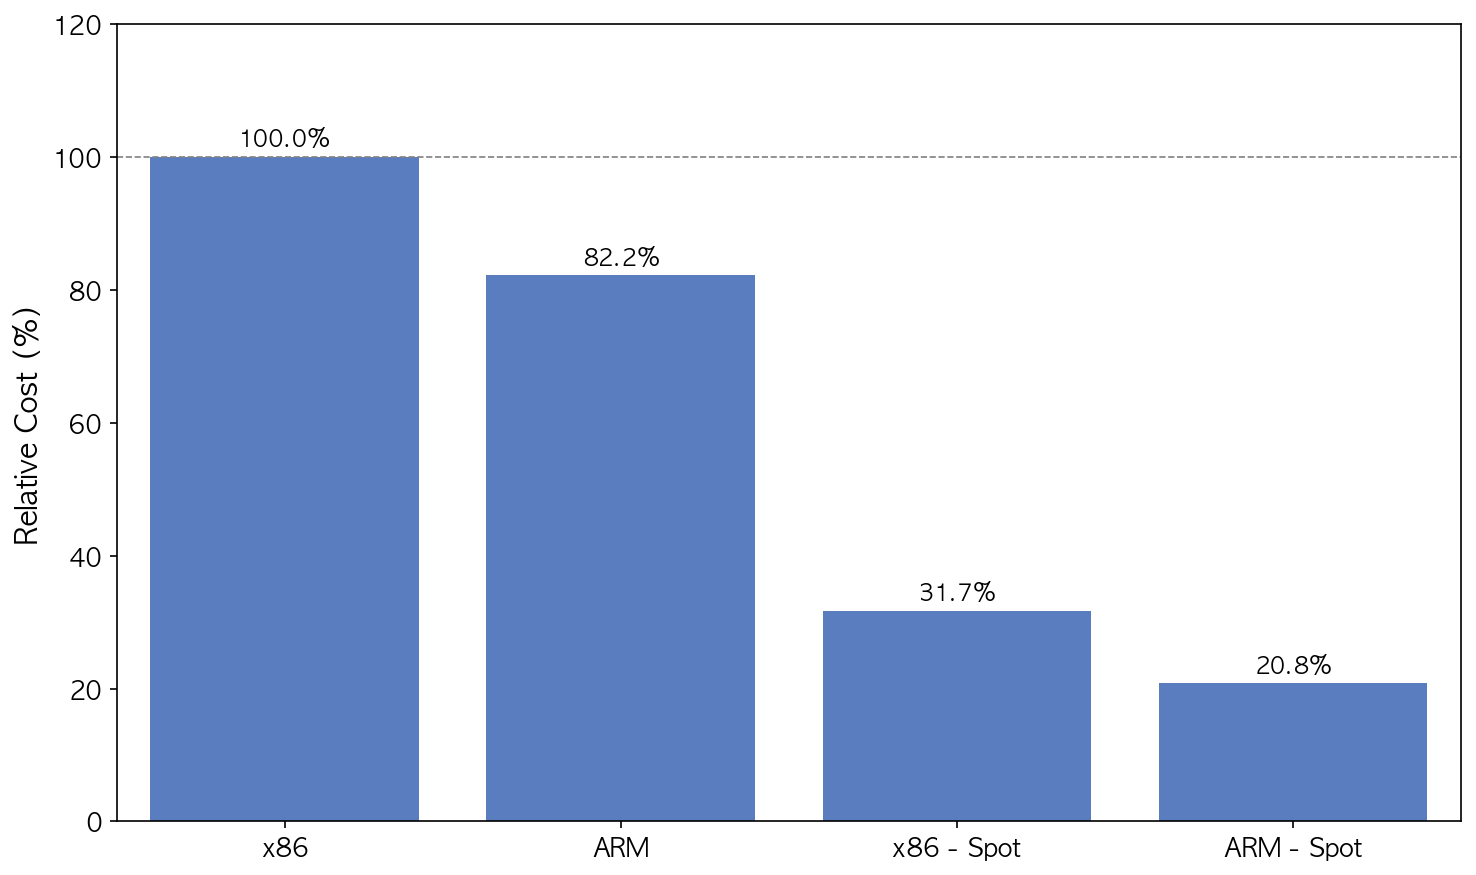

In [11]:
plt.style.use("default")
plt.rcParams["font.family"] = FONT_FAMILY
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams.update({"font.size": BASE_FONT_SIZE})
plt.rcParams.update({"axes.labelsize": LABEL_FONT_SIZE})
plt.rcParams.update({"axes.titlesize": TITLE_FONT_SIZE})
plt.rcParams.update({"xtick.labelsize": BASE_FONT_SIZE})
plt.rcParams.update({"ytick.labelsize": BASE_FONT_SIZE})
plt.rcParams["axes.grid"] = False

fig, ax1 = plt.subplots(figsize=(10, 6), dpi=150)
category_order = ["x86", "ARM", "x86 - Spot", "ARM - Spot"]
palette = [UNIFIED_COLOR] * len([cat for cat in category_order if cat in plot_df_avg["Category"].values])

ax1 = sns.barplot(
    data=plot_df_avg,
    x="Category",
    y="Avg_Relative_Cost_Percent",
    order=[cat for cat in category_order if cat in plot_df_avg["Category"].values],
    palette=palette,
    hue="Category",
    dodge=False,
    legend=False,
)

ax1.set_ylabel("Relative Cost (%)", color="black")
ax1.set_xlabel("")
ax1.tick_params(axis="x", rotation=0)
ax1.tick_params(axis="y", labelcolor="black")
ax1.grid(False)
ax1.axhline(100, color="gray", linestyle="--", linewidth=0.8)

# 막대 상단에 값 표시
if not plot_df_avg.empty:
    for i, bar in enumerate(ax1.patches):
        height = bar.get_height()
        if not pd.isna(height):
            label_text = f"{height:.1f}%"
            ax1.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 1,
                label_text,
                ha="center",
                va="bottom",
                color="black",
                fontsize=ANNOTATION_FONT_SIZE,
                bbox=dict(facecolor="white", alpha=0.7, pad=1, edgecolor="none"),
            )

if not plot_df_avg.empty:
    max_rel_cost = plot_df_avg["Avg_Relative_Cost_Percent"].max()
    padding_top = max_rel_cost * 0.15 if not pd.isna(max_rel_cost) else 15
    top_limit = max(max_rel_cost + padding_top if not pd.isna(max_rel_cost) else 0, 120)
    ax1.set_ylim(0, top_limit)
else:
    ax1.set_ylim(0, 120)

plt.tight_layout()
plt.savefig("x86_vs_arm_comparison.pdf", bbox_inches="tight")
plt.savefig("x86_vs_arm_comparison.png", bbox_inches="tight", dpi=300)
plt.show()

## 6. 비교 결과 상세 출력
패밀리별 비교 결과와 최종 평균 플롯 데이터를 출력합니다.

In [12]:
print("--- 패밀리별 비교 결과 상세 ---")
print(comparison_df.to_string())
print("\n--- 최종 평균 플롯 데이터 ---")
print(plot_df_avg.to_string())

--- 패밀리별 비교 결과 상세 ---
  ARM_Instance Baseline_x86_Instance  Relative_OD_Cost_%  Relative_Spot_Cost_%  Relative_Perf_%  Original_Perf_Gain_%
0    t4g.large              t3.large           80.000000             19.134615            140.0                  40.0
1   m6g.xlarge             m5.xlarge           79.661017             15.720339            140.0                  40.0
2   m7g.xlarge             m5.xlarge           85.000000             23.347458            150.0                  50.0
3   c6g.xlarge             c5.xlarge           80.208333             24.427083            140.0                  40.0
4   c7g.xlarge             c5.xlarge           85.000000             30.000000            155.0                  55.0
5   r6g.xlarge             r5.xlarge           80.263158             19.276316            140.0                  40.0
6   r7g.xlarge             r5.xlarge           85.000000             13.618421            150.0                  50.0

--- 최종 평균 플롯 데이터 ---
     Categor